In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import texplot
from glob import glob
from pprint import pprint
from os.path import join
import freealg as fa
import time
from scipy.stats import wasserstein_distance, ks_2samp

In [24]:
# ===============
# total variation
# ===============

def total_variation(x, pdf, pdf_pred):
    """
    L1 total-variation distance
    """
    
    return 0.5 * np.trapz(np.abs(pdf_pred - pdf), x)


# =======================
# jensen shannon distance
# =======================

def jensen_shannon_distance(x, pdf, pdf_pred, eps=1e-12):
    """
    Jensen–Shannon distance (sqrt of divergence).
    Adds eps to avoid log(0) and renormalizes internally.
    """
    
    # Ensure valid densities and normalize
    p = pdf + eps
    q = pdf_pred + eps
    p /= np.trapz(p, x)
    q /= np.trapz(q, x)

    m = 0.5 * (p + q)
    kl_pm = np.trapz(p * np.log2(p / m), x)
    kl_qm = np.trapz(q * np.log2(q / m), x)
    js_div = 0.5 * (kl_pm + kl_qm)

    return np.sqrt(js_div)

# ===========
# wasserstein
# ===========

def wasserstein(eig_true, eig_pred):
    return wasserstein_distance(eig_true, eig_pred)


# ==========
# kolmogorov
# ==========

def kolmogorov(eig_true, eig_pred):
    # pass raw eigen‑samples, not KDEs
    return ks_2samp(eig_true, eig_pred).statistic
    

# ===============
# moment from pdf
# ===============

def moment_from_pdf(pdf, x, k):
    """
    k-th raw moment.
    """
    
    mass = np.trapz(pdf, x)
    return np.trapz((x**k) * pdf / mass, x)


# ===============
# moment from eig
# ===============

def moment_from_eig(eig, k):
    """
    k‑th raw moment of the empirical spectrum (no KDE).
    """
    
    eig = np.asarray(eig)
    return np.mean(eig**k)
    

# ======================
# relatoive moment error
# ======================

def relative_moment_error(x, eig, pdf_pred, k):
    """
    Relative error in k-th moment.
    """

    m_true = moment_from_eig(eig, k)
    m_pred = moment_from_pdf(pdf_pred, x, k)
    return abs(m_pred - m_true) / abs(m_true)
    

# =====
# table
# =====

def table(data):

    # Extract results from data
    subsizes = data['subsizes']                  # matrix subsizes
    x_pred = data['x_pred']                      # x axis for the KDE
    eigs = data['eigs']                          # exact eigenvalues
    pdfs = data['pdfs']                          # exact densities (KDE of exact eigenvalues)
    batch_rhos_pred = data['batch_rhos_pred']    # predicted density
    batch_eigs_pred = data['batch_eigs_pred']    # Quasi monte-carlo samples rhos_pred
    batch_pdfs_pred = data['batch_pdfs_pred']    # KDE of pdfs_pred

    n_batch = len(batch_pdfs_pred)
    n_subsizes = len(subsizes)
    
    tv = numpy.zeros((n_batch, n_subsizes), dtype=float)
    js = numpy.zeros((n_batch, n_subsizes), dtype=float)
    w1 = numpy.zeros((n_batch, n_subsizes), dtype=float)
    ks = numpy.zeros((n_batch, n_subsizes), dtype=float)
    m1 = numpy.zeros((n_batch, n_subsizes), dtype=float)
    m2 = numpy.zeros((n_batch, n_subsizes), dtype=float)

    # All metrics (except Wasserstein) are between [0, 1].
    for j in range(n_batch):
        for i in range(n_subsizes):
            w1[j, i] = 100.0 * wasserstein(eigs[i], batch_eigs_pred[j][i])  # In the unit of eigenvalues (not between 0 and 1)

            # The rest have values in [0, 1]
            tv[j, i] = 100.0 * total_variation(x_pred, pdfs[i], batch_pdfs_pred[j][i])
            js[j, i] = 100.0 * jensen_shannon_distance(x_pred, pdfs[i], batch_pdfs_pred[j][i])
            ks[j, i] = 100.0 * kolmogorov(eigs[i], batch_eigs_pred[j][i])
            m1[j, i] = 100.0 * relative_moment_error(x_pred, eigs[i], batch_pdfs_pred[j][i], 1)
            m2[j, i] = 100.0 * relative_moment_error(x_pred, eigs[i], batch_pdfs_pred[j][i], 2)

    return subsizes, w1, tv, js, ks, m1, m2

In [25]:
data = numpy.load('plot_data_cifar_ntk_batch.npy', allow_pickle=True).item()
subsizes, w1_, tv_, js_, ks_, m1_, m2_ = table(data)

# Filter outliers
mask = numpy.ones((tv_.shape[0],), dtype=bool)
mask[6] = False
mask[9] = False

w1 = w1_[mask]
tv = tv_[mask]
js = js_[mask]
ks = ks_[mask]
m1 = m1_[mask]
m2 = m2_[mask]

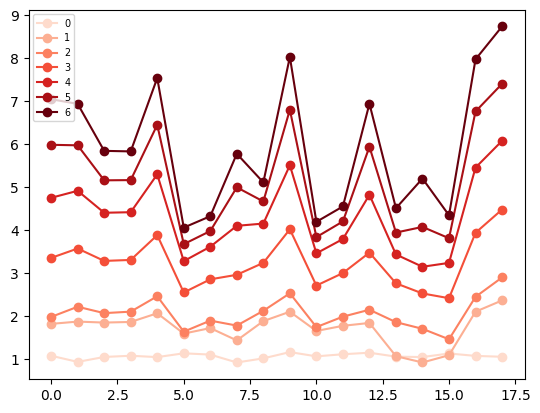

In [26]:
n_batch, n_subsizes = tv.shape
batch_range = numpy.arange(n_batch)

num_plots = n_subsizes
cmap = plt.get_cmap('Reds')
colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]

for i in range(n_subsizes):
    plt.plot(batch_range, tv[:, i], '-o', color=colors[i], label=str(i))
plt.legend(fontsize='x-small')

In [29]:
w1_m = w1.mean(axis=0)
w1_s = w1.std(axis=0)
w1_cv = 100.0 * w1_s / w1_m

tv_m = tv.mean(axis=0)
tv_s = tv.std(axis=0)
tv_cv = 100.0 * tv_s / tv_m

js_m = js.mean(axis=0)
js_s = js.std(axis=0)
js_cv = 100.0 * js_s / js_m

ks_m = ks.mean(axis=0)
ks_s = ks.std(axis=0)
ks_cv = 100.0 * ks_s / ks_m

m1_m = m1.mean(axis=0)
m1_s = m1.std(axis=0)
m1_cv = 100.0 * m1_s / m1_m

m2_m = m2.mean(axis=0)
m2_s = m2.std(axis=0)
m2_cv = 100.0 * m2_s / m2_m

print('|  size | '
      '    W1 (x100)     | '
      '    TV (x100)     | '
      '    JS (x100)     | '
      '    KS (x100)     | '
      '    M1 (x100)     | '
      '    M2 (x100)     |')

pm = "\u00B1"
for i in range(n_subsizes):
    print(f'| {subsizes[i]:>5d} | '
          f'{w1_m[i]:>0.2f} {pm} {w1_s[i]:>0.2f} ({w1_cv[i]:>2.0f}%) | '
          f'{tv_m[i]:>0.2f} {pm} {tv_s[i]:>0.2f} ({tv_cv[i]:>2.0f}%) | '
          f'{js_m[i]:>0.2f} {pm} {js_s[i]:>0.2f} ({js_cv[i]:>2.0f}%) | '
          f'{ks_m[i]:>0.2f} {pm} {ks_s[i]:>0.2f} ({ks_cv[i]:>2.0f}%) | '
          f'{m1_m[i]:>0.2f} {pm} {m1_s[i]:>0.2f} ({m1_cv[i]:>2.0f}%) | '
          f'{m2_m[i]:>0.2f} {pm} {m2_s[i]:>0.2f} ({m2_cv[i]:>2.0f}%) |')

|  size |     W1 (x100)     |     TV (x100)     |     JS (x100)     |     KS (x100)     |     M1 (x100)     |     M2 (x100)     |
|  1024 | 0.08 ± 0.02 (22%) | 1.06 ± 0.06 ( 6%) | 3.79 ± 0.29 ( 8%) | 0.42 ± 0.05 (13%) | 0.01 ± 0.00 (46%) | 0.01 ± 0.01 (45%) |
|  2048 | 0.31 ± 0.12 (38%) | 1.72 ± 0.37 (22%) | 7.60 ± 1.99 (26%) | 0.48 ± 0.10 (21%) | 0.05 ± 0.03 (53%) | 0.09 ± 0.04 (51%) |
|  4096 | 0.48 ± 0.09 (18%) | 2.06 ± 0.35 (17%) | 4.67 ± 0.67 (14%) | 0.70 ± 0.12 (17%) | 0.01 ± 0.01 (83%) | 0.02 ± 0.02 (82%) |
|  8192 | 1.19 ± 0.22 (18%) | 3.24 ± 0.56 (17%) | 6.30 ± 0.51 ( 8%) | 1.18 ± 0.22 (19%) | 0.01 ± 0.00 (44%) | 0.02 ± 0.01 (42%) |
| 16384 | 2.58 ± 0.50 (19%) | 4.33 ± 0.87 (20%) | 7.55 ± 0.80 (11%) | 1.76 ± 0.48 (27%) | 0.01 ± 0.01 (39%) | 0.03 ± 0.01 (32%) |
| 32768 | 4.92 ± 1.02 (21%) | 5.16 ± 1.18 (23%) | 7.96 ± 1.11 (14%) | 2.51 ± 0.84 (34%) | 0.02 ± 0.01 (41%) | 0.05 ± 0.02 (36%) |
| 50056 | 7.38 ± 1.23 (17%) | 5.94 ± 1.48 (25%) | 8.33 ± 1.41 (17%) | 3.02 ± 1.14 (38%) | 